In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode

from embrapa_api.preprocessing.preprocessors import BasePreprocessor
from embrapa_api.config import PROJECT_FOLDER

# Processamento

In [10]:
processing_dict = {
    "Viniferas": {
        "url": 'http://vitibrasil.cnpuv.embrapa.br/download/ProcessaViniferas.csv',
        "path": f'{PROJECT_FOLDER}/data/csv_files/processamento_vinho/ProcessaViniferas.csv'
},
    "Americanas": {
        "url": 'http://vitibrasil.cnpuv.embrapa.br/download/ProcessaAmericanas.csv',
        "path": f'{PROJECT_FOLDER}/data/csv_files/processamento_vinho/ProcessaAmericanas.csv'
    },
    "Uvas de mesa": {
        "url": 'http://vitibrasil.cnpuv.embrapa.br/download/ProcessaMesa.csv',
        "path": f'{PROJECT_FOLDER}/data/csv_files/processamento_vinho/ProcessaMesa.csv'
    },
    "Sem Classe": {
        "url": 'http://vitibrasil.cnpuv.embrapa.br/download/ProcessaSemClasse.csv',
        "path": f'{PROJECT_FOLDER}/data/csv_files/processamento_vinho/ProcessaSemclass.csv'
    }
}

In [102]:
def processa_uvas_processadas(data, tipo_uva):
    CD_TIPO_UVA_MAP = {
        "ti": "Tintas",
        "br": "Brancas e Rosadas",
    }
    EXPECTED_AGG_TIPO_VINHO = set(['TINTAS', 'BRANCAS E ROSADAS'])
    rf_tipo_uva = tipo_uva.lower().replace(" ", "_")

    rf_data = (
        data
        .melt(
            id_vars=["id", "control", "cultivar"],
            var_name="ano",
            value_name="uvas_processadas_Kg"
        )
        .rename(columns={
            "id": "ID_UVA_PROCESSADA",
            "control": "NM_CONTROLE",
            "cultivar": "NM_UVA",
            "ano": "DT_ANO",
            "uvas_processadas_Kg": "QT_UVAS_PROCESSADAS_KG"
        })
    )
    rf_data["CD_TIPO_VINHO"] = (
        rf_data["NM_CONTROLE"]
        .str.split("_").str[0]
        .map(CD_TIPO_UVA_MAP)
    )

    rf_data = (
        rf_data
        .query("CD_TIPO_VINHO.notnull()")
        .drop(columns=["NM_CONTROLE"])
    )

    rf_data["QT_UVAS_PROCESSADAS_KG"] = rf_data["QT_UVAS_PROCESSADAS_KG"].apply(
        lambda x: float(x) if isinstance(x, (int, float)) else None)

    rf_data = (
        rf_data
        .assign(CD_TIPO_UVA=rf_tipo_uva)
        .astype({
            "ID_UVA_PROCESSADA": str,
            "NM_UVA": str,
            "DT_ANO": int,
            "CD_TIPO_VINHO": str,
            "CD_TIPO_UVA": str,
            "QT_UVAS_PROCESSADAS_KG": float
        })
    )
    assert (rf_data.groupby(["ID_UVA_PROCESSADA"])["NM_UVA"].nunique(
    ) == 1).all, "garantir que o nome da uva é única por ID_UVA_PROCESSADA"
    
    rf_data["ID_UVA_PROCESSADA"] = rf_data["ID_UVA_PROCESSADA"] + "_" + rf_data["CD_TIPO_UVA"]

    return rf_data

In [110]:
"Uvas de mesa".replace(" ", "_").upper()

'UVAS_DE_MESA'

In [101]:
processamento.query("CD_TIPO_UVA != 'Viniferas'").head(1)

,ID_UVA_PROCESSADA,ID_CONTROLE,NM_CULTIVAR,DT_ANO,QT_UVAS_PROCESSADAS_VINIFERAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
1,2,ti_Alicante Bouschet,Alicante Bouschet,1970,0.0,Tintas,Americanas


In [113]:
processamento.groupby(["ID_UVA_PROCESSADA", "CD_TIddPO_UVA"])["NM_CULTIVAR"].nunique().sort_values(ascending=False)

ID_UVA_PROCESSADA  CD_TIPO_UVA
29                 Americanas     2
61                 Viniferas      1
63                 Viniferas      1
64                 Viniferas      1
65                 Viniferas      1
                                 ..
32                 Viniferas      1
33                 Americanas     1
                   Viniferas      1
34                 Americanas     1
134                Viniferas      1
Name: NM_CULTIVAR, Length: 198, dtype: int64

In [115]:
processamento.query("ID_UVA_PROCESSADA == 29").groupby(["ID_UVA_PROCESSADA", "NM_CULTIVAR", "CD_TIPO_UVA"]).head(1)

,ID_UVA_PROCESSADA,ID_CONTROLE,NM_CULTIVAR,DT_ANO,QT_UVAS_PROCESSADAS_VINIFERAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
28,29,ti_Gamay St Romain,Gamay St Romain,1970,0.0,Tintas,Viniferas
10,29,ti_BRS Rúbea,BRS Rúbea,1970,0.0,Tintas,Americanas
28,29,ti_Othello,Othello,1970,33013.0,Tintas,Americanas


In [76]:
(
    processamento
    .groupby(["NM_CULTIVAR", "CD_TIPO_UVA"])
    ["QT_UVAS_PROCESSADAS_VINIFERAS_KG"]
    .sum()
    .reset_index()
    .sort_values(by=["QT_UVAS_PROCESSADAS_VINIFERAS_KG"], ascending=False)
).head(10)

,NM_CULTIVAR,CD_TIPO_UVA,QT_UVAS_PROCESSADAS_VINIFERAS_KG
70,Moscato Branco,Brancas e Rosadas,641830181.0
121,Trebbiano,Brancas e Rosadas,444306945.0
63,Merlot,Tintas,274422818.0
99,Riesling Italico,Brancas e Rosadas,233201919.0
16,Cabernet Sauvignon,Tintas,229412912.0
15,Cabernet Franc,Tintas,227836723.0
12,Barbera,Tintas,139660107.0
23,Chardonnay,Brancas e Rosadas,127656102.0
108,Semillon,Brancas e Rosadas,115452921.0
111,Tannat,Tintas,80952006.0


In [67]:
processamento["ID_CONTROLE"].str.split("_").str[0].value_counts()

ID_CONTROLE
ti    3604
br    3392
Name: count, dtype: int64

In [65]:
(
    processamento
    #.query("ID_CONTROLE.str.startswith('br')")
    .groupby(["ID_CONTROLE", "NM_CULTIVAR"])
    ["VR_UVAS_PROCESSADAS_VINIFERAS_KG"]
    .sum()
    .reset_index()
    .sort_values(
        by=["VR_UVAS_PROCESSADAS_VINIFERAS_KG"],
        ascending=False)
    .head(20)
)

,ID_CONTROLE,NM_CULTIVAR,VR_UVAS_PROCESSADAS_VINIFERAS_KG
34,br_Moscato_branco,Moscato Branco,641830181.0
56,br_Trebbiano,Trebbiano,444306945.0
101,ti_Merlot,Merlot,274422818.0
47,br_Riesling Italico,Riesling Italico,233201919.0
74,ti_Cabernet Sauvignon,Cabernet Sauvignon,229412912.0
73,ti_Cabernet Franc,Cabernet Franc,227836723.0
71,ti_Barbera,Barbera,139660107.0
7,br_Chardonnay,Chardonnay,127656102.0
53,br_Semillon,Semillon,115452921.0
120,ti_Tannat,Tannat,80952006.0


In [48]:
valores_unicos = processamento["VR_UVAS_PROCESSADAS_VINIFERAS_KG"].unique()

valores_unicos_nao_numericos = [x for x in valores_unicos if not isinstance(x, (int, float))]


In [37]:
(processamento.groupby(["NM_CULTIVAR", "DT_ANO"])["ID_CONTROLE"].nunique() != 1).sum()

0

## Teste

In [111]:
tipo_uva = "Viniferas"

try:
    2 + "e"
    data = pd.read_csv(processing_dict[tipo_uva]["url"], sep='\t')
    
except Exception as e:
    print(e)
    data = pd.read_csv(processing_dict[tipo_uva]["path"], sep='\t')

rf_viniferas = processa_uvas_processadas(data, tipo_uva)

unsupported operand type(s) for +: 'int' and 'str'


In [112]:
rf_viniferas

,ID_UVA_PROCESSADA,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
1,2_viniferas,Alicante Bouschet,1970,0.0,Tintas,viniferas
2,3_viniferas,Ancelota,1970,0.0,Tintas,viniferas
3,4_viniferas,Aramon,1970,0.0,Tintas,viniferas
4,5_viniferas,Alfrocheiro,1970,0.0,Tintas,viniferas
5,6_viniferas,Arinarnoa,1970,0.0,Tintas,viniferas
...,...,...,...,...,...,...
7097,130_viniferas,Verdiso,2022,NaN,Brancas e Rosadas,viniferas
7098,131_viniferas,Vermentino,2022,NaN,Brancas e Rosadas,viniferas
7099,132_viniferas,Vernaccia,2022,NaN,Brancas e Rosadas,viniferas
7100,133_viniferas,Viognier,2022,NaN,Brancas e Rosadas,viniferas


In [122]:
tipo_uva = "Americanas"

try:
    2 + "e"
    data = pd.read_csv(processing_dict[tipo_uva]["url"], sep='\t')
    
except Exception as e:
    print(e)
    data = pd.read_csv(processing_dict[tipo_uva]["path"], sep='\t')

rf_americanas = processa_uvas_processadas(data, tipo_uva)

unsupported operand type(s) for +: 'int' and 'str'


In [110]:
rf_americanas.head()

,ID_UVA_PROCESSADA,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
1,2_americanas,Bacarina,1970,82899.0,Tintas,americanas
2,3_americanas,Bailey,1970,0.0,Tintas,americanas
3,4_americanas,Bordo,1970,7242197.0,Tintas,americanas
4,5_americanas,Bourdin (S),1970,0.0,Tintas,americanas
5,6_americanas,BRS Carmen,1970,0.0,Tintas,americanas


In [119]:
tipo_uva = "Uvas de mesa"

try:
    2 + "e"
    data = pd.read_csv(processing_dict[tipo_uva]["url"], sep='\t')
    
except Exception as e:
    print(e)
    data = pd.read_csv(processing_dict[tipo_uva]["path"], sep='\t')

rf_uvas_mesa = processa_uvas_processadas(data, tipo_uva)

unsupported operand type(s) for +: 'int' and 'str'


In [120]:
data

,id,control,cultivar,1970,1971,1972,1973,1974,1975,1976,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1,TINTAS,TINTAS,56976,43390,4428,8939,125563,183731,88512,...,75362,65850,108797,51310,85510,62567,nd,63474,21732,*
1,2,ti_ Alphonse Lavallee,Alphonse Lavallee,31878,2333,170,7690,124762,74293,23684,...,0,0,0,0,0,0,nd,0,0,*
2,3,ti_ Moscato de Hamburgo,Moscato de Hamburgo,25098,41057,4258,1249,801,109438,64828,...,75362,65850,108797,51310,85510,62567,nd,63474,21732,*
3,4,BRANCAS,BRANCAS,3900,16335,6829,8052,278951,587745,153445,...,4412,30600,64540,3260,5900,730,nd,45610,52760,*
4,5,br_Cardinal,Cardinal,0,0,0,0,0,0,0,...,0,0,0,0,0,0,nd,0,0,*
5,6,br_Golden Queen,Golden Queen,167,8654,657,7312,8467,6805,0,...,0,0,0,0,0,0,nd,0,0,*
6,7,br_Patrícia,Patrícia,0,0,0,0,0,0,0,...,0,0,0,0,0,0,nd,0,0,*
7,8,br_Perlona,Perlona,0,0,4027,0,1695,1223,1406,...,3378,850,3280,290,180,730,nd,0,1710,*
8,9,br_Italia,Italia,3733,7681,2145,740,268789,579717,152039,...,0,0,0,0,0,0,nd,0,0,*
9,10,"br_Rubi (Itália, Itália Ro)","Rubi (Itália, Itália Ro)",0,0,0,0,0,0,0,...,1034,29750,61260,2970,5720,0,nd,45610,51050,*


In [121]:
rf_uvas_mesa["CD_TIPO_VINHO"].unique()

array(['Tintas', 'Brancas e Rosadas'], dtype=object)

In [116]:
rf_uvas_mesa.head()

,ID_UVA_PROCESSADA,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
1,2_uvas_de_mesa,Alphonse Lavallee,1970,31878.0,Tintas,uvas_de_mesa
2,3_uvas_de_mesa,Moscato de Hamburgo,1970,25098.0,Tintas,uvas_de_mesa
4,5_uvas_de_mesa,Cardinal,1970,0.0,Brancas e Rosadas,uvas_de_mesa
5,6_uvas_de_mesa,Golden Queen,1970,167.0,Brancas e Rosadas,uvas_de_mesa
6,7_uvas_de_mesa,Patrícia,1970,0.0,Brancas e Rosadas,uvas_de_mesa


In [106]:
tipo_uva = "Sem Classe"

try:
    2 + "e"
    data = pd.read_csv(processing_dict[tipo_uva]["url"], sep='\t')
    
except Exception as e:
    print(e)
    data = pd.read_csv(processing_dict[tipo_uva]["path"], sep='\t')

rf_sem_classe = processa_uvas_processadas(data, tipo_uva)

unsupported operand type(s) for +: 'int' and 'str'


In [107]:
rf_sem_classe.head()

,ID_UVA_PROCESSADA,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA


# Linha a Linha

In [113]:
tipo_uva = "Sem Classe"

try:
    2 + "e"
    data = pd.read_csv(processing_dict[tipo_uva]["url"], sep='\t')
    
except Exception as e:
    print(e)
    data = pd.read_csv(processing_dict[tipo_uva]["path"], sep='\t')

unsupported operand type(s) for +: 'int' and 'str'


In [114]:
data

,id,control,cultivar,1970,1971,1972,1973,1974,1975,1976,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1,sc,Sem classificação,3675463,665425,197232,491357,57307,540146,24440,...,0,0,0,0,0,0,nd,166947,0,*


In [95]:
CD_TIPO_UVA_MAP = {
    "ti": "Tintas",
    "br": "Brancas e Rosadas",
}
EXPECTED_AGG_TIPO_VINHO = set(['TINTAS', 'BRANCAS E ROSADAS'])

rf_data = (
    data
    .melt(
        id_vars=["id", "control", "cultivar"],
        var_name="ano",
        value_name="uvas_processadas_Kg"
    )
    .rename(columns={
        "id": "ID_UVA_PROCESSADA",
        "control": "NM_CONTROLE",
        "cultivar": "NM_UVA",
        "ano": "DT_ANO",
        "uvas_processadas_Kg": "QT_UVAS_PROCESSADAS_KG"
    })
)
rf_data["CD_TIPO_VINHO"] = (
    rf_data["NM_CONTROLE"]
    .str.split("_").str[0]
    .map(CD_TIPO_UVA_MAP)
)


In [97]:
EXPECTED_AGG_TIPO_VINHO

{'BRANCAS E ROSADAS', 'TINTAS'}

In [96]:
set(rf_data.query("CD_TIPO_VINHO.isnull()")["NM_UVA"].unique())

{'BRANCAS', 'TINTAS'}

In [98]:
rf_data.head()

,ID_UVA_PROCESSADA,NM_CONTROLE,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO
0,1,TINTAS,TINTAS,1970,56976,NaN
1,2,ti_ Alphonse Lavallee,Alphonse Lavallee,1970,31878,Tintas
2,3,ti_ Moscato de Hamburgo,Moscato de Hamburgo,1970,25098,Tintas
3,4,BRANCAS,BRANCAS,1970,3900,NaN
4,5,br_Cardinal,Cardinal,1970,0,Brancas e Rosadas


In [101]:
data.tail(10)

,id,control,cultivar,1970,1971,1972,1973,1974,1975,1976,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1,TINTAS,TINTAS,56976,43390,4428,8939,125563,183731,88512,...,75362,65850,108797,51310,85510,62567,nd,63474,21732,*
1,2,ti_ Alphonse Lavallee,Alphonse Lavallee,31878,2333,170,7690,124762,74293,23684,...,0,0,0,0,0,0,nd,0,0,*
2,3,ti_ Moscato de Hamburgo,Moscato de Hamburgo,25098,41057,4258,1249,801,109438,64828,...,75362,65850,108797,51310,85510,62567,nd,63474,21732,*
3,4,BRANCAS,BRANCAS,3900,16335,6829,8052,278951,587745,153445,...,4412,30600,64540,3260,5900,730,nd,45610,52760,*
4,5,br_Cardinal,Cardinal,0,0,0,0,0,0,0,...,0,0,0,0,0,0,nd,0,0,*
5,6,br_Golden Queen,Golden Queen,167,8654,657,7312,8467,6805,0,...,0,0,0,0,0,0,nd,0,0,*
6,7,br_Patrícia,Patrícia,0,0,0,0,0,0,0,...,0,0,0,0,0,0,nd,0,0,*
7,8,br_Perlona,Perlona,0,0,4027,0,1695,1223,1406,...,3378,850,3280,290,180,730,nd,0,1710,*
8,9,br_Italia,Italia,3733,7681,2145,740,268789,579717,152039,...,0,0,0,0,0,0,nd,0,0,*
9,10,"br_Rubi (Itália, Itália Ro)","Rubi (Itália, Itália Ro)",0,0,0,0,0,0,0,...,1034,29750,61260,2970,5720,0,nd,45610,51050,*


In [99]:
rf_data.tail()

,ID_UVA_PROCESSADA,NM_CONTROLE,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO
525,6,br_Golden Queen,Golden Queen,2022,*,Brancas e Rosadas
526,7,br_Patrícia,Patrícia,2022,*,Brancas e Rosadas
527,8,br_Perlona,Perlona,2022,*,Brancas e Rosadas
528,9,br_Italia,Italia,2022,*,Brancas e Rosadas
529,10,"br_Rubi (Itália, Itália Ro)","Rubi (Itália, Itália Ro)",2022,*,Brancas e Rosadas


In [ ]:


assert set(rf_data.query("CD_TIPO_VINHO.isnull()")["NM_UVA"].unique()) == EXPECTED_AGG_TIPO_VINHO, "garantir que os valores nulos são os valores agregados"


In [ ]:

rf_data = (
    rf_data
    .query("CD_TIPO_VINHO.notnull()")
    .drop(columns=["NM_CONTROLE"])
)

In [54]:
tipo_uva

'Viniferas'

In [60]:

rf_data["QT_UVAS_PROCESSADAS_KG"] = rf_data["QT_UVAS_PROCESSADAS_KG"].apply(lambda x: float(x) if isinstance(x, (int, float)) else None)

rf_data = (
    rf_data
    .assign(CD_TIPO_UVA=tipo_uva)
    .astype({
        "ID_UVA_PROCESSADA": int,
        "NM_UVA": str,
        "DT_ANO": int,
        "CD_TIPO_VINHO": str,
        "CD_TIPO_UVA": str,
        "QT_UVAS_PROCESSADAS_KG": float
    })
)
assert (rf_data.groupby(["ID_UVA_PROCESSADA"])["NM_UVA"].nunique() == 1).all, "garantir que o nome da uva é única por ID_UVA_PROCESSADA"


In [61]:
rf_data.head()

,ID_UVA_PROCESSADA,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
1,2,Alicante Bouschet,1970,0.0,Tintas,Viniferas
2,3,Ancelota,1970,0.0,Tintas,Viniferas
3,4,Aramon,1970,0.0,Tintas,Viniferas
4,5,Alfrocheiro,1970,0.0,Tintas,Viniferas
5,6,Arinarnoa,1970,0.0,Tintas,Viniferas


# Testing Class

In [1]:
from embrapa_api.preprocessing.preprocessors import ProcessamentoPreprocessor

In [2]:
ProcessamentoPreprocessor

embrapa_api.preprocessing.preprocessors.ProcessamentoPreprocessor

In [3]:
processamentoPreprocessor = ProcessamentoPreprocessor()

In [4]:
processamento_df = processamentoPreprocessor.preprocess()

Failed to load data from URL. Loading from local file.
HTTP Error 404: Not Found


In [5]:
processamento_df.head()

,ID_UVA_PROCESSADA,NM_UVA,DT_ANO,QT_UVAS_PROCESSADAS_KG,CD_TIPO_VINHO,CD_TIPO_UVA
97,100_viniferas,Moscato Canelli,1970,0.0,Brancas e Rosadas,viniferas
229,100_viniferas,Moscato Canelli,1971,0.0,Brancas e Rosadas,viniferas
361,100_viniferas,Moscato Canelli,1972,0.0,Brancas e Rosadas,viniferas
493,100_viniferas,Moscato Canelli,1973,0.0,Brancas e Rosadas,viniferas
625,100_viniferas,Moscato Canelli,1974,0.0,Brancas e Rosadas,viniferas


<Axes: xlabel='DT_ANO'>

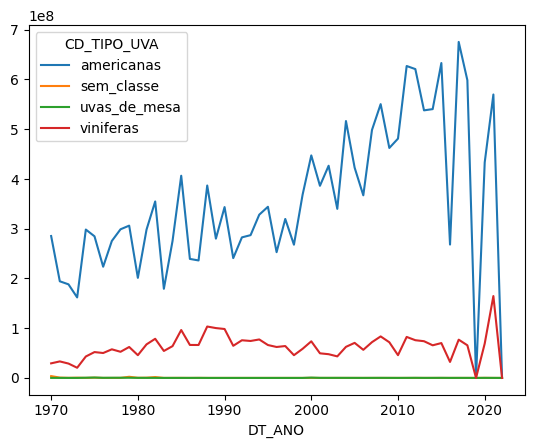

In [13]:
from matplotlib import pyplot as plt

(
    processamento_df
    .groupby(["DT_ANO", "CD_TIPO_UVA"])
    ["QT_UVAS_PROCESSADAS_KG"]
    .sum()
    .reset_index()
    .sort_values(by=["DT_ANO", "CD_TIPO_UVA"])
    .pivot(index="DT_ANO", columns="CD_TIPO_UVA", values="QT_UVAS_PROCESSADAS_KG")
).plot()

In [6]:
processamento_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10547 entries, 97 to 6871
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_UVA_PROCESSADA       10547 non-null  object 
 1   NM_UVA                  10547 non-null  object 
 2   DT_ANO                  10547 non-null  object 
 3   QT_UVAS_PROCESSADAS_KG  10149 non-null  float64
 4   CD_TIPO_VINHO           10547 non-null  object 
 5   CD_TIPO_UVA             10547 non-null  object 
dtypes: float64(1), object(5)
memory usage: 576.8+ KB
